In [1]:
import tensorflow as tf
from keras.layers import (Input, Dense, BatchNormalization, Flatten, Reshape, 
                          Lambda, Conv2D, Conv2DTranspose,LeakyReLU)
from keras.models import Model
from keras.optimizers import Adam
from keras import initializers
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops,smart_cond
import keras.backend as K

In [2]:
image_size=64
batch_size = 32
latent_dim = 64
start_lr = 1e-6

In [3]:
def encoder_function(input_img):
    #He initialization for Relu activated layers
    Heinitializer = initializers.HeNormal()

    x = Conv2D(filters=64, kernel_size=4, strides=2,padding='same',use_bias=False,
               kernel_initializer=Heinitializer)(input_img)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=128, kernel_size=4, strides=2,padding='same',use_bias=False,
               kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=256, kernel_size=4, strides=2,padding='same',use_bias=False,
               kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=512, kernel_size=4, strides=2,padding='same',use_bias=False,
               kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=4096, kernel_size=4, strides=1,padding='valid',use_bias=False,
               kernel_initializer=Heinitializer)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Flatten()(x)
    
    
    #Predict mean of standard distribution and logarithm of variance
    #Initialize initial logvar to be very small, 
    #So latent variables do not become completely random and lose the meaning
    Logvar_initializer=initializers.Constant(value=-10)
    Xavierinitializer=initializers.GlorotNormal()

    z_mean = Dense(latent_dim,kernel_initializer=Xavierinitializer,bias_initializer=Xavierinitializer)(x)
    z_log_var = Dense(latent_dim, kernel_initializer=Xavierinitializer,bias_initializer=Logvar_initializer)(x)

    return z_mean,z_log_var

In [4]:
def get_decoder(activation):
    def decoder_function(z):
        #He initialization for Relu activated layers
        Heinitializer = initializers.HeNormal()

        x = Reshape(target_shape=(1, 1, 64))(z)

        x = Conv2DTranspose(filters=512, kernel_size=4, strides=1,padding='valid',use_bias=False,
                            kernel_initializer=Heinitializer)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2DTranspose(filters=256, kernel_size=4, strides=2,padding='same',use_bias=False,
                            kernel_initializer=Heinitializer)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2DTranspose(filters=128, kernel_size=4, strides=2,padding='same',use_bias=False,
                            kernel_initializer=Heinitializer)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2DTranspose(filters=64, kernel_size=4, strides=2,padding='same',use_bias=False,
                            kernel_initializer=Heinitializer)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        #Xavier intialization for differentiable functions activated layers
        Xavierinitializer=initializers.GlorotNormal()
        if activation=='':
            decoded = Conv2DTranspose(filters=1, kernel_size=4, strides=2,padding='same',use_bias=False
                                    ,kernel_initializer=Xavierinitializer)(x)
        else:
            decoded = Conv2DTranspose(filters=1, kernel_size=4, strides=2,padding='same',use_bias=False,
                                  activation=activation,kernel_initializer=Xavierinitializer)(x)

        return decoded
    return decoder_function

In [5]:
def get_reconstruction_loss(loss_type='chi_sq'):

    #Chose original loss function
    if (loss_type=='chi_sq') or (loss_type=='mse'):
        loss_function=tf.math.squared_difference
    if loss_type=='binary_crossentropy':
        loss_function=K.binary_crossentropy

    def reconstruction_loss_function(y_true,y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)

        reconstruction_loss=loss_function(y_true,y_pred)

        #cast mse to chi_square by adding weights
        if (loss_type=='chi_sq'):
            #Poisson weights (sigma=sqrt(image))
            weights=tf.math.pow(tf.sqrt(tf.abs(y_true)+1e-5),-1)
            weights= math_ops.cast(weights, y_pred.dtype)
            reconstruction_loss=reconstruction_loss*weights

        return K.mean(reconstruction_loss,axis=-1)

    return reconstruction_loss_function

In [6]:
def get_model_loss(beta_vae=1e-3,loss_type='chi_sq'):
    reconstruction_loss_function=get_reconstruction_loss(loss_type)

    def model_loss_function(x,decoded):

        #reconstruction quality
        flattened_x=K.reshape(x,shape=(len(x),image_size*image_size))
        flattened_decoded=K.reshape(decoded,shape=(len(decoded),image_size*image_size))
        reconstruction_loss=image_size*image_size*reconstruction_loss_function(flattened_x,flattened_decoded)

        #KL divergence regularization quality
        mean = models['z_meaner'](x)
        logvar=models['z_log_varer'](x)
        KL_loss=0.5 * K.sum(1 + logvar - K.square(mean) - K.exp(logvar), axis=-1)

        Beta_VAE_Loss=(reconstruction_loss-beta_vae*KL_loss)/image_size/image_size
        return Beta_VAE_Loss

    return model_loss_function,reconstruction_loss_function

In [7]:
def create_vae(beta_vae=1e-3,activation='softplus',loss_type='chi_sq'):

    #Reparametrization trick
    def reparameterize(args):
        mean,logvar=args
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar/2) + mean


    decoder_function=get_decoder(activation)
    model_loss_function,reconstruction_loss_function=get_model_loss(beta_vae,loss_type)


    #VAE
    models = {}

    #Encoder
    input_img = Input(batch_shape=(batch_size, image_size, image_size, 1))

    z_mean, z_log_var=encoder_function(input_img)

    l=Lambda(reparameterize, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, name='Encoder') 
    models["z_meaner"] = Model(input_img, z_mean, name='Enc_z_mean')
    models["z_log_varer"] = Model(input_img, z_log_var, name='Enc_z_log_var')

    #Decoder
    z = Input(shape=(latent_dim, ))
    decoded=decoder_function(z)

    models["decoder"] = Model(z, decoded, name='Decoder')
    models["vae"]     = Model(input_img, models["decoder"](models["encoder"](input_img)), name="VAE")

    return models,model_loss_function,reconstruction_loss_function

In [8]:
def get_Neural_Network(beta_vae=1e-3,activation='softplus',loss_type='chi_sq'):
    with tf.device('/device:GPU:0'):
        models,model_loss_function,reconstruction_loss_function= create_vae(beta_vae,activation,loss_type)
        models["vae"].compile(optimizer=Adam(learning_rate=start_lr, beta_1=0.5, beta_2=0.999,clipvalue=0.1), 
                              loss=model_loss_function)
        return models,model_loss_function,reconstruction_loss_function

## Load a model

In [10]:
beta_vae=1e-3
activation='softplus'
loss_type='chi_sq'
models,model_loss_function,reconstruction_loss_function=get_Neural_Network(beta_vae,activation,loss_type)

In [11]:
import os

In [12]:
os.path.join(os.getcwd(), 'data', 'base')

'/Users/austinpeel/Software/python/galaxy-vae/dev-notebooks/data/base'

In [13]:
for k in models.keys():
    print(k)

encoder
z_meaner
z_log_varer
decoder
vae


In [14]:
checkpoint = '/Users/austinpeel/Software/python/galaxy-vae/data/epoch_320/Model'
models['vae'].load_weights(checkpoint)
encoder_weights = models['encoder'].get_weights()
decoder_weights = models['decoder'].get_weights()

encoder_weights = [jnp.array(w) for w in encoder_weights]
decoder_weights = [jnp.array(w) for w in decoder_weights]

In [15]:
vae_tf = models['vae']
encoder_tf = models['encoder']
decoder_tf = models['decoder']

In [16]:
encoder_tf.layers

In [17]:
decoder_tf.layers

In [18]:
for i, w in enumerate(decoder_weights):
    print(f'{i:2}: {w.shape}')

 0: (4, 4, 512, 64)
 1: (512,)
 2: (512,)
 3: (512,)
 4: (512,)
 5: (4, 4, 256, 512)
 6: (256,)
 7: (256,)
 8: (256,)
 9: (256,)
10: (4, 4, 128, 256)
11: (128,)
12: (128,)
13: (128,)
14: (128,)
15: (4, 4, 64, 128)
16: (64,)
17: (64,)
18: (64,)
19: (64,)
20: (4, 4, 1, 64)


In [19]:
for i, w in enumerate(encoder_weights):
    print(f'{i:2}: {w.shape}')

 0: (4, 4, 1, 64)
 1: (4, 4, 64, 128)
 2: (128,)
 3: (128,)
 4: (128,)
 5: (128,)
 6: (4, 4, 128, 256)
 7: (256,)
 8: (256,)
 9: (256,)
10: (256,)
11: (4, 4, 256, 512)
12: (512,)
13: (512,)
14: (512,)
15: (512,)
16: (4, 4, 512, 4096)
17: (4096, 64)
18: (64,)
19: (4096, 64)
20: (64,)


In [35]:
models['z_meaner'].get_weights()[18]

array([-0.03607206,  0.226308  , -0.22996154, -0.00760088, -0.25990087,
        0.0086865 ,  0.01873955, -0.02613028,  0.15182847, -0.0059599 ,
        0.05050728, -0.03551071,  0.18490903, -0.00381583, -0.06801917,
        0.03954849, -0.07574396,  0.06284802,  0.09500168, -0.17467418,
        0.06188508,  0.03056237,  0.0821493 ,  0.07256949,  0.03355469,
        0.06893885,  0.14909877, -0.00735749,  0.03063714, -0.07172196,
        0.08460348,  0.2810998 ,  0.00778355,  0.02230872, -0.02279896,
        0.20574175, -0.10070538, -0.05720329, -0.09787963,  0.11189447,
       -0.0999905 ,  0.02911525,  0.1982547 , -0.14535163,  0.08385505,
       -0.02836546, -0.02787953, -0.21618086, -0.06666051, -0.19128656,
       -0.03962134,  0.17387792, -0.00403129, -0.02523759,  0.12922947,
       -0.00712307,  0.03493008, -0.04890649,  0.07285206,  0.2524235 ,
       -0.10076681,  0.04276151,  0.0082577 , -0.12512967], dtype=float32)

## Load weights into JAX VAE

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.ndimage.filters import gaussian_filter as gf
# from tqdm import tqdm

# Basic JAX
import jax
from jax import random, tree_map, numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# JAX neural networks
import flax.linen as nn
from flax import optim
from flax.core import freeze, unfreeze
from jax.nn.initializers import he_normal

In [37]:
class Encoder(nn.Module):
    zdim: int
    
    @nn.compact
    def __call__(self, x, train: bool = True):
        # Common arguments
        kwargs = {'kernel_size': (4, 4),
                  'strides': (2, 2),
                  'padding': 'SAME',
                  'use_bias': False,
                  'kernel_init': he_normal()}
        
        # x = np.reshape(x, (64, 64, 1))
        x = x[..., None]
        
        # Layer 1
        x = nn.Conv(features=64, **kwargs)(x)
        x = nn.leaky_relu(x, 0.2)

        # Layer 2
        x = nn.Conv(features=128, **kwargs)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x, 0.2)
        
        # Layer 3
        x = nn.Conv(features=256, **kwargs)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x, 0.2)
        
        # Layer 4
        x = nn.Conv(features=512, **kwargs)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x, 0.2)
    
        # Layer 5
        x = nn.Conv(features=4096, kernel_size=(4, 4), strides=(1, 1), padding='VALID', 
                    use_bias=False, kernel_init=he_normal())(x)
        x = nn.leaky_relu(x, 0.2)
    
        # Flatten
        x = x.flatten()
    
        # Predict latent variables
        z_mean = nn.Dense(features=self.zdim)(x)
        z_logvar = nn.Dense(features=self.zdim)(x)
        
        return z_mean, z_logvar
    
class Decoder(nn.Module):
    zdim: int
    
    @nn.compact
    def __call__(self, z, train: bool = True):
        # Common arguments
        conv_kwargs = {'kernel_size': (4, 4),
                       'strides': (2, 2),
                       'padding': 'SAME',
                       'use_bias': False,
                       'kernel_init': he_normal()}
        norm_kwargs = {'use_running_average': not train,
                       'momentum': 0.99,
                       'epsilon': 0.001,
                       'use_scale': True,
                       'use_bias': True}
        
        z = np.reshape(z, (1, 1, self.zdim))
        
        # Layer 1
        z = nn.ConvTranspose(features=512, kernel_size=(4, 4), strides=(1, 1), padding='VALID',
                             use_bias=False, kernel_init=he_normal())(z)
        z = nn.BatchNorm(**norm_kwargs)(z)
        z = nn.leaky_relu(z, 0.2)
        
        # Layer 2
        z = nn.ConvTranspose(features=256, **conv_kwargs)(z)
        z = nn.BatchNorm(**norm_kwargs)(z)
        z = nn.leaky_relu(z, 0.2)
        
        # Layer 3
        z = nn.ConvTranspose(features=128, **conv_kwargs)(z)
        z = nn.BatchNorm(**norm_kwargs)(z)
        z = nn.leaky_relu(z, 0.2)
        
        # Layer 4
        z = nn.ConvTranspose(features=64, **conv_kwargs)(z)
        z = nn.BatchNorm(**norm_kwargs)(z)
        z = nn.leaky_relu(z, 0.2)
        
        # Layer 5
        z = nn.ConvTranspose(features=1, kernel_size=(4, 4), strides=(2, 2), padding='SAME',
                             use_bias=False, kernel_init=nn.initializers.xavier_normal())(z)
        # x = nn.sigmoid(z)
        x = nn.softplus(z)
        
        return jnp.rot90(np.squeeze(x), k=2)  # Rotate to match TF output
    
class VAE(nn.Module):
    zdim: int
    
    def setup(self):
        self.encoder = Encoder(self.zdim)
        self.decoder = Decoder(self.zdim)
        
    def __call__(self, x, z_rng, train: bool = True):
        z_mean, z_logvar = self.encoder(x, train)
        z = self.reparameterize(z_rng, z_mean, z_logvar)
        x_rec = self.decoder(z, train)
        return x_rec, z_mean, z_logvar
    
    def decode(self, params, z):
        return vae.apply(params, z, method=self._decode)
    
    def _decode(self, z):
        return self.decoder(z, train=False)
    
    @staticmethod
    def reparameterize(rng, mean, logvar):
        std = jnp.exp(0.5 * logvar)
        eps = random.normal(rng, logvar.shape)
        return mean + eps * std

## Load weights from TF model

In [38]:
xdim = 64  # image (64, 64)
zdim = 64

encoder = Encoder(zdim)
decoder = Decoder(zdim)
vae = VAE(zdim)

In [39]:
key, subkey1, subkey2 = random.split(random.PRNGKey(42), 3)
# init_data = jnp.ones((1, 1, zdim))
# params = decoder.init(subkey, init_data)
init_data = jnp.ones((xdim, xdim))
params = vae.init(subkey1, init_data, z_rng=subkey2)
tree_map(jnp.shape, params)

FrozenDict({
    batch_stats: {
        decoder: {
            BatchNorm_0: {
                mean: (512,),
                var: (512,),
            },
            BatchNorm_1: {
                mean: (256,),
                var: (256,),
            },
            BatchNorm_2: {
                mean: (128,),
                var: (128,),
            },
            BatchNorm_3: {
                mean: (64,),
                var: (64,),
            },
        },
        encoder: {
            BatchNorm_0: {
                mean: (128,),
                var: (128,),
            },
            BatchNorm_1: {
                mean: (256,),
                var: (256,),
            },
            BatchNorm_2: {
                mean: (512,),
                var: (512,),
            },
        },
    },
    params: {
        decoder: {
            BatchNorm_0: {
                bias: (512,),
                scale: (512,),
            },
            BatchNorm_1: {
                bias: (256,),
   

In [40]:
# Replace encoder weights
unfrozen_params = unfreeze(params)
unfrozen_params['params']['encoder']['Conv_0']['kernel'] = encoder_weights[0]
unfrozen_params['params']['encoder']['Conv_1']['kernel'] = encoder_weights[1]
unfrozen_params['params']['encoder']['BatchNorm_0']['scale'] = encoder_weights[2]
unfrozen_params['params']['encoder']['BatchNorm_0']['bias'] = encoder_weights[3]
unfrozen_params['batch_stats']['encoder']['BatchNorm_0']['mean'] = encoder_weights[4]
unfrozen_params['batch_stats']['encoder']['BatchNorm_0']['var'] = encoder_weights[5]
unfrozen_params['params']['encoder']['Conv_2']['kernel'] = encoder_weights[6]
unfrozen_params['params']['encoder']['BatchNorm_1']['scale'] = encoder_weights[7]
unfrozen_params['params']['encoder']['BatchNorm_1']['bias'] = encoder_weights[8]
unfrozen_params['batch_stats']['encoder']['BatchNorm_1']['mean'] = encoder_weights[9]
unfrozen_params['batch_stats']['encoder']['BatchNorm_1']['var'] = encoder_weights[10]
unfrozen_params['params']['encoder']['Conv_3']['kernel'] = encoder_weights[11]
unfrozen_params['params']['encoder']['BatchNorm_2']['scale'] = encoder_weights[12]
unfrozen_params['params']['encoder']['BatchNorm_2']['bias'] = encoder_weights[13]
unfrozen_params['batch_stats']['encoder']['BatchNorm_2']['mean'] = encoder_weights[14]
unfrozen_params['batch_stats']['encoder']['BatchNorm_2']['var'] = encoder_weights[15]
unfrozen_params['params']['encoder']['Conv_4']['kernel'] = encoder_weights[16]
unfrozen_params['params']['encoder']['Dense_0']['kernel'] = encoder_weights[17]
unfrozen_params['params']['encoder']['Dense_0']['bias'] = encoder_weights[18]
unfrozen_params['params']['encoder']['Dense_1']['kernel'] = encoder_weights[19]
unfrozen_params['params']['encoder']['Dense_1']['bias'] = encoder_weights[20]

# Replace decoder weights
unfrozen_params['params']['decoder']['ConvTranspose_0']['kernel'] = np.swapaxes(decoder_weights[0], 2, 3)
unfrozen_params['params']['decoder']['BatchNorm_0']['scale'] = decoder_weights[1]
unfrozen_params['params']['decoder']['BatchNorm_0']['bias'] = decoder_weights[2]
unfrozen_params['batch_stats']['decoder']['BatchNorm_0']['mean'] = decoder_weights[3]
unfrozen_params['batch_stats']['decoder']['BatchNorm_0']['var'] = decoder_weights[4]
unfrozen_params['params']['decoder']['ConvTranspose_1']['kernel'] = np.swapaxes(decoder_weights[5], 2, 3)
unfrozen_params['params']['decoder']['BatchNorm_1']['scale'] = decoder_weights[6]
unfrozen_params['params']['decoder']['BatchNorm_1']['bias'] = decoder_weights[7]
unfrozen_params['batch_stats']['decoder']['BatchNorm_1']['mean'] = decoder_weights[8]
unfrozen_params['batch_stats']['decoder']['BatchNorm_1']['var'] = decoder_weights[9]
unfrozen_params['params']['decoder']['ConvTranspose_2']['kernel'] = np.swapaxes(decoder_weights[10], 2, 3)
unfrozen_params['params']['decoder']['BatchNorm_2']['scale'] = decoder_weights[11]
unfrozen_params['params']['decoder']['BatchNorm_2']['bias'] = decoder_weights[12]
unfrozen_params['batch_stats']['decoder']['BatchNorm_2']['mean'] = decoder_weights[13]
unfrozen_params['batch_stats']['decoder']['BatchNorm_2']['var'] = decoder_weights[14]
unfrozen_params['params']['decoder']['ConvTranspose_3']['kernel'] = np.swapaxes(decoder_weights[15], 2, 3)
unfrozen_params['params']['decoder']['BatchNorm_3']['scale'] = decoder_weights[16]
unfrozen_params['params']['decoder']['BatchNorm_3']['bias'] = decoder_weights[17]
unfrozen_params['batch_stats']['decoder']['BatchNorm_3']['mean'] = decoder_weights[18]
unfrozen_params['batch_stats']['decoder']['BatchNorm_3']['var'] = decoder_weights[19]
unfrozen_params['params']['decoder']['ConvTranspose_4']['kernel'] = np.swapaxes(decoder_weights[20], 2, 3)
params = freeze(unfrozen_params)

# Replace only decoder weights
# unfrozen_params = unfreeze(params)
# unfrozen_params['params']['ConvTranspose_0']['kernel'] = np.swapaxes(decoder_weights[0], 2, 3)
# unfrozen_params['params']['BatchNorm_0']['scale'] = decoder_weights[1]
# unfrozen_params['params']['BatchNorm_0']['bias'] = decoder_weights[2]
# unfrozen_params['batch_stats']['BatchNorm_0']['mean'] = decoder_weights[3]
# unfrozen_params['batch_stats']['BatchNorm_0']['var'] = decoder_weights[4]
# unfrozen_params['params']['ConvTranspose_1']['kernel'] = np.swapaxes(decoder_weights[5], 2, 3)
# unfrozen_params['params']['BatchNorm_1']['scale'] = decoder_weights[6]
# unfrozen_params['params']['BatchNorm_1']['bias'] = decoder_weights[7]
# unfrozen_params['batch_stats']['BatchNorm_1']['mean'] = decoder_weights[8]
# unfrozen_params['batch_stats']['BatchNorm_1']['var'] = decoder_weights[9]
# unfrozen_params['params']['ConvTranspose_2']['kernel'] = np.swapaxes(decoder_weights[10], 2, 3)
# unfrozen_params['params']['BatchNorm_2']['scale'] = decoder_weights[11]
# unfrozen_params['params']['BatchNorm_2']['bias'] = decoder_weights[12]
# unfrozen_params['batch_stats']['BatchNorm_2']['mean'] = decoder_weights[13]
# unfrozen_params['batch_stats']['BatchNorm_2']['var'] = decoder_weights[14]
# unfrozen_params['params']['ConvTranspose_3']['kernel'] = np.swapaxes(decoder_weights[15], 2, 3)
# unfrozen_params['params']['BatchNorm_3']['scale'] = decoder_weights[16]
# unfrozen_params['params']['BatchNorm_3']['bias'] = decoder_weights[17]
# unfrozen_params['batch_stats']['BatchNorm_3']['mean'] = decoder_weights[18]
# unfrozen_params['batch_stats']['BatchNorm_3']['var'] = decoder_weights[19]
# unfrozen_params['params']['ConvTranspose_4']['kernel'] = np.swapaxes(decoder_weights[20], 2, 3)
# params = freeze(unfrozen_params)

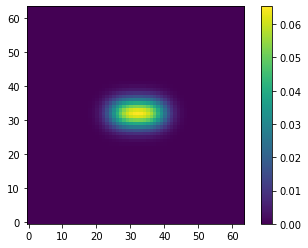

In [65]:
# key, subkey = random.split(key)
# z = random.normal(subkey, (1, 1, 64))
# x = decoder.apply(params, z, train=False)
x = np.zeros((xdim, xdim))
x[xdim // 2, xdim // 2] = 1
x[xdim // 2, xdim // 2 - 2] = 1
x[xdim // 2, xdim // 2 - 4] = 1
x[xdim // 2, xdim // 2 - 6] = 1
x[xdim // 2, xdim // 2 + 2] = 1
x[xdim // 2, xdim // 2 + 4] = 1
x[xdim // 2, xdim // 2 + 6] = 1

x_true = gf(x, 3)

fig, ax = plt.subplots(1, 1)
img = ax.imshow(x_true, origin='lower')
fig.colorbar(img)

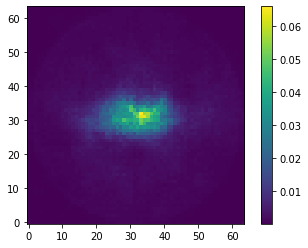

In [66]:
key, subkey = random.split(key)
x_rec = vae.apply(params, x_true, z_rng=subkey, train=False)

fig, ax = plt.subplots(1, 1)
img = ax.imshow(x_rec[0], origin='lower')
fig.colorbar(img)

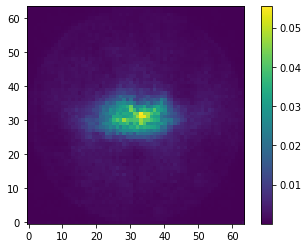

In [67]:
x_rec_tf = np.squeeze(vae_tf(x_true[None, ..., None]))
fig, ax = plt.subplots(1, 1)
img = ax.imshow(x_rec_tf, origin='lower')
fig.colorbar(img)

## Test just the decoder

In [41]:
# key, subkey = random.split(key)
# z = random.normal(subkey, (1, 1, zdim))
# x = decoder.apply(decoder_params, z, train=False)
# x_rec = vae.apply(params, z, method=vae._decode)
x_rec = vae.decode(params, z)
x_rec.shape

(64, 64)

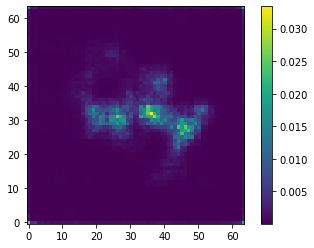

In [42]:
fig, ax = plt.subplots(1, 1)
img = ax.imshow(x_rec, origin='lower')
fig.colorbar(img)

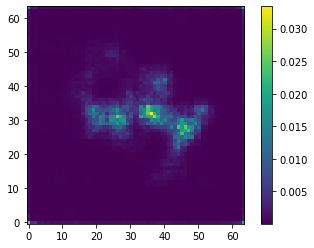

In [31]:
x_rec_tf = np.squeeze(decoder_tf(np.array(z[0])))

fig, ax = plt.subplots(1, 1)
img = ax.imshow(x_rec_tf, origin='lower')
fig.colorbar(img)

## Can we differentiate wrt z ? (YES)

In [149]:
def loss(z):
    x_rec = vae.apply(params, z, method=vae._decode)
    return jnp.sum((x_true - x_rec)**2) / 2

@jax.jit
def grad_loss(z):
    return jnp.squeeze(jax.grad(loss)(z))

@jax.jit
def hess_loss(z):
    return jnp.squeeze(jax.hessian(loss)(z))

In [153]:
key, subkey = random.split(key)
z_current = random.normal(subkey, ((1, 64)))
loss(z_current)

DeviceArray(0.18976327, dtype=float64)

In [154]:
grad_loss(z_current)

Buffer([-0.01255387, -0.00168787,  0.03273134, -0.02204758,  0.03308836,
        -0.00861002,  0.01278384,  0.00519522,  0.03527437, -0.00071918,
        -0.00628908, -0.01239578, -0.02725351, -0.01526702,  0.01276483,
         0.01210221,  0.01522147,  0.01118725, -0.00839118,  0.00865552,
        -0.00836884,  0.02085181,  0.01757636, -0.02409693,  0.00232838,
         0.01425546,  0.01758219, -0.01059118,  0.00181972, -0.00166388,
         0.00442546,  0.00524286, -0.01052691,  0.00027303, -0.00017721,
         0.02437173, -0.00120721,  0.01640207, -0.01212517,  0.00157719,
        -0.0239323 , -0.0161502 ,  0.02486473, -0.00133514,  0.00206976,
        -0.00943239, -0.01604187,  0.00988377, -0.01883834,  0.00813398,
        -0.0112985 ,  0.00628785,  0.00704195,  0.0014617 , -0.01050278,
         0.01673628,  0.01559182,  0.0161937 ,  0.00572071, -0.01900192,
         0.01667552,  0.00876774,  0.01731476,  0.00045822],       dtype=float64)

In [155]:
hess_loss(z_current)

Buffer([[ 0.00475314, -0.00061995, -0.00613802, ..., -0.00174962,
         -0.00291408,  0.00117937],
        [-0.00061995,  0.00247427, -0.00166243, ..., -0.00048089,
         -0.0007127 , -0.00083843],
        [-0.00613802, -0.00166243,  0.01779021, ...,  0.00435956,
          0.00883097,  0.00090992],
        ...,
        [-0.00174962, -0.00048089,  0.00435956, ...,  0.00196121,
          0.00238083,  0.00060473],
        [-0.00291407, -0.0007127 ,  0.00883096, ...,  0.00238083,
          0.00554991,  0.00119164],
        [ 0.00117937, -0.00083843,  0.00090992, ...,  0.00060473,
          0.00119164,  0.00295011]], dtype=float64)

In [91]:
from scipy.optimize import minimize

In [156]:
key, subkey = random.split(key)
# z0 = random.normal(subkey, (64,))
z0 = jnp.zeros((64,))

In [157]:
opt = minimize(loss, z0, method='trust-krylov', jac=grad_loss, hess=hess_loss)

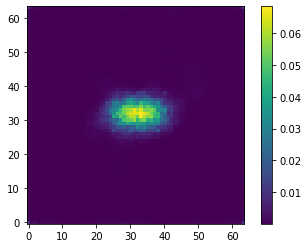

In [136]:
fig, ax = plt.subplots(1, 1)
img = ax.imshow(vae.apply(params, opt.x, method=vae._decode), origin='lower')
fig.colorbar(img)

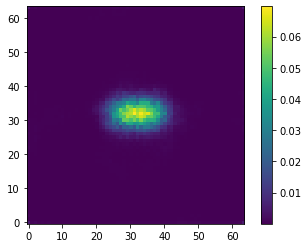

In [158]:
fig, ax = plt.subplots(1, 1)
img = ax.imshow(vae.apply(params, opt.x, method=vae._decode), origin='lower')
fig.colorbar(img)

In [159]:
opt

     fun: DeviceArray(0.00122344, dtype=float64)
    hess: array([[ 0.00579926, -0.00287813, -0.00195293, ...,  0.00225548,
         0.00169035,  0.00246765],
       [-0.00287813,  0.00990254,  0.00171645, ..., -0.0057547 ,
        -0.00604895,  0.00491799],
       [-0.00195293,  0.00171645,  0.00219664, ..., -0.00026174,
        -0.00035175,  0.00018584],
       ...,
       [ 0.00225548, -0.0057547 , -0.00026175, ...,  0.00667861,
         0.00629077, -0.0018814 ],
       [ 0.00169035, -0.00604895, -0.00035175, ...,  0.00629077,
         0.00856291, -0.003437  ],
       [ 0.00246765,  0.00491799,  0.00018584, ..., -0.0018814 ,
        -0.003437  ,  0.007849  ]])
     jac: array([ 4.02391106e-06, -1.40304346e-05,  6.94828304e-06,  1.95225653e-06,
       -8.96340339e-07,  2.75491197e-06, -3.57461613e-06,  7.49642368e-07,
        2.84917587e-06,  7.97547091e-06, -2.25445137e-06,  4.49631784e-07,
        5.77217907e-06, -8.77713228e-06,  3.90502237e-06, -2.77546678e-06,
        1.09318589